<a href="https://colab.research.google.com/github/Kanekohe/masterthesis/blob/main/Exercise_20201104.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 練習問題(2020.11.4)
Trancated Gaussian distributionからのサンプリング

Trancated Gaussina distributionは$c$を定数として，
$$
p(x) \propto \int_{-\infty}^c \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
$$
とする．

pythonのscipyには組み込み関数として,ある?みたい?だが，ここではRejection Samplingでサンプリングしてみる．



まずは，関数を見てみる．

$\mu=0.0$, $\sigma=1.0$, $c=0.5$として，プロットする．ただし，規格化定数は正しくない．

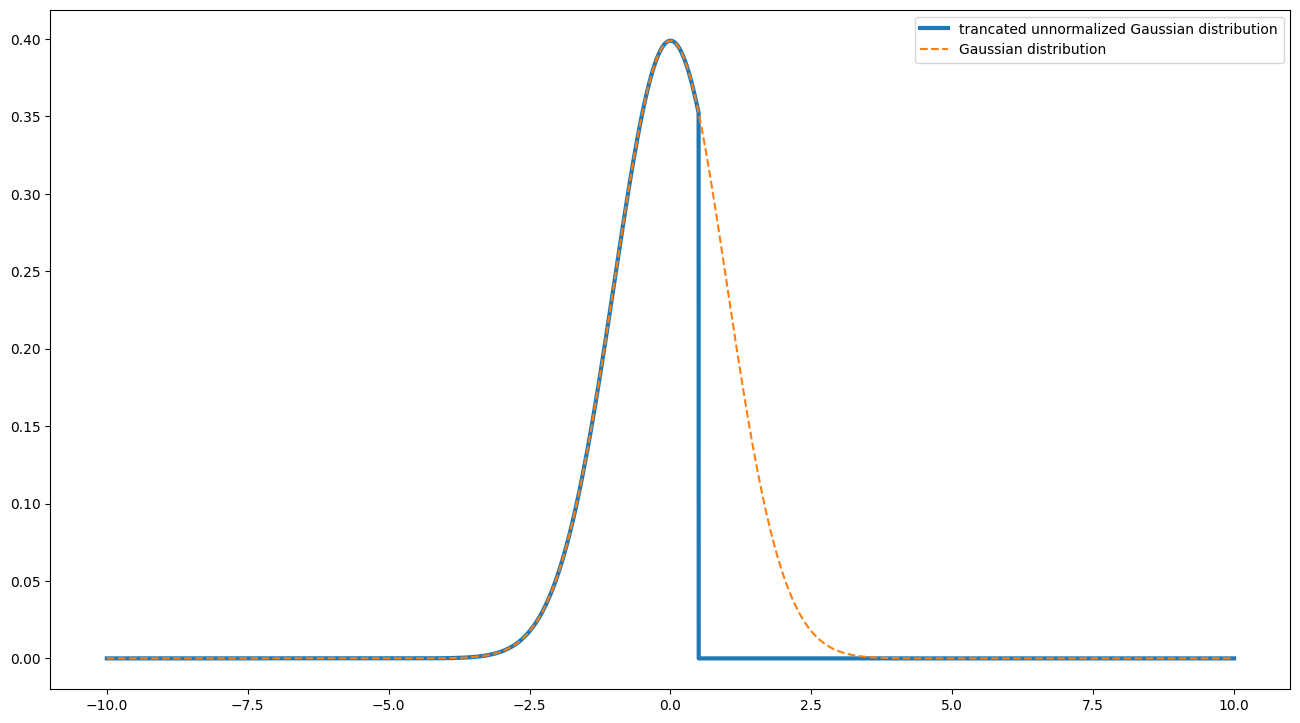

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

def p(x, c):
    if x > c: 
        return 0
    else:
        return stats.norm.pdf(x, loc=0, scale=1.0) 

def q(x):
    return stats.norm.pdf(x, loc=0, scale=1.0)

c=0.5
x = np.linspace(-10.0, 10.0, 10000)
y = np.array([p(z,c) for z in x])
fig = plt.figure(dpi=100, figsize=(16,9))
plt.plot(x, y,label="trancated unnormalized Gaussian distribution",linewidth=3)
plt.plot(x, q(x),label="Gaussian distribution",linestyle='dashed')
plt.legend()
plt.show()

## Rejection Samplingの実行
繰り返し回数10000として，Rejection Samplingをしてみた．

正しいTrancated Gaussian distributionと並べるとよかったかもしれないが，規格化定数を計算するのが面倒だったので，規格化していないまま．．．なんとなくできていそう．

今回は提案分布と実際のサンプリングしたい分布との相対比のパラメータ$k$は1になっているが，幾つかの点でその大きさをチェックしている．

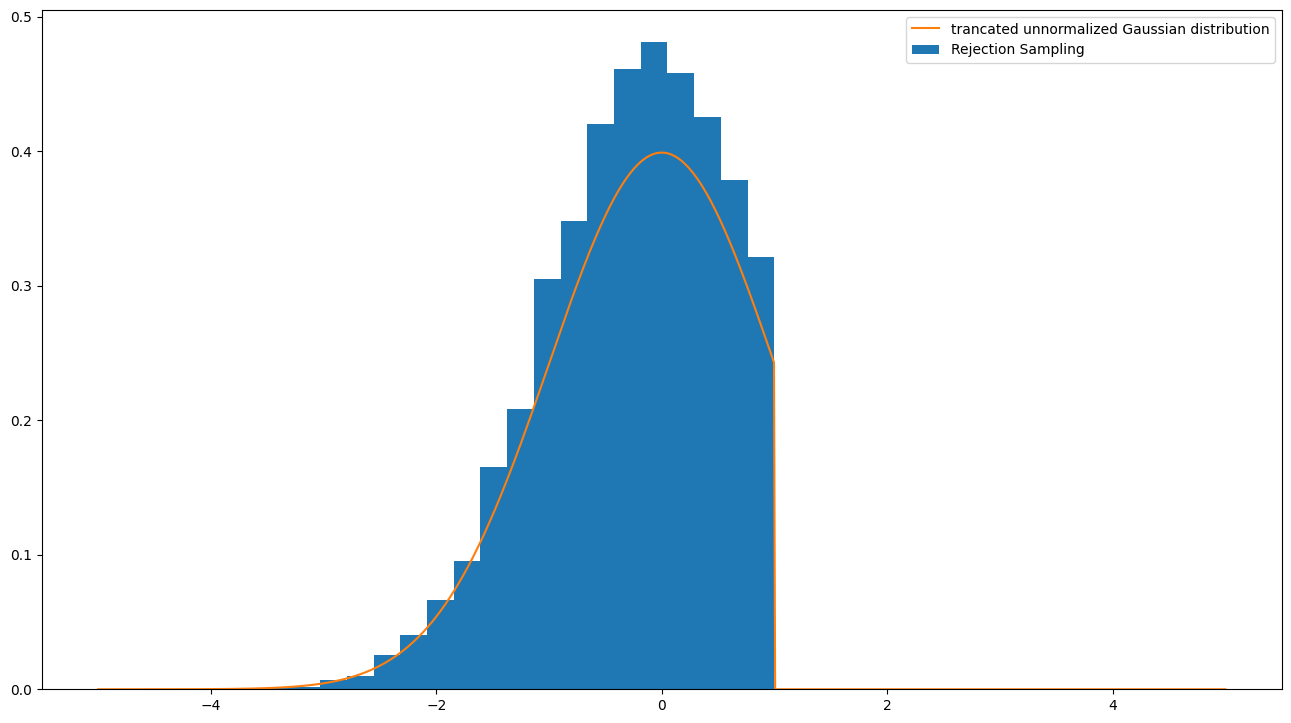

In [ ]:
def rejection_sampling(iter=1000):
    samples = []

    for i in range(iter):
        z = np.random.normal(0, 1.0)
        u = np.random.uniform(0, k*q(z))

        if u <= p(z,c):
            samples.append(z)

    return np.array(samples)

y = []
x = np.arange(-5, 5)
for z in x:
    y.append(p(z,c)/q(z))
k = max(y)
c=1.0
s = rejection_sampling(iter=10000)
fig = plt.figure(dpi=100, figsize=(16,9))
plt.hist(s,bins=20, density=True, label="Rejection Sampling")
x = np.linspace(-5.0, 5.0, 1000)
y = np.array([p(z,c) for z in x])
plt.plot(x, y,label="trancated unnormalized Gaussian distribution")
plt.legend()
plt.show()

## 期待値の計算
せっかくなので，切断パラメータを変えてこの分布の期待値の計算をしてみよう．

解析的には期待値は以下のように求まる：
$$
\langle X \rangle(c) = \mu -\frac{\phi(\frac{c-\mu}{\sigma})}{\Psi(\frac{c-\mu}{\sigma})}\sigma
$$
ここで，$\phi$は正規分布であり，$\Psi$は累積正規分布である．

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-4.0 0
-3.111111111111111 0
-2.2222222222222223 2
-1.3333333333333335 8
-0.44444444444444464 32
0.44444444444444464 66
1.333333333333333 87
2.2222222222222214 100
3.1111111111111107 100
4.0 100


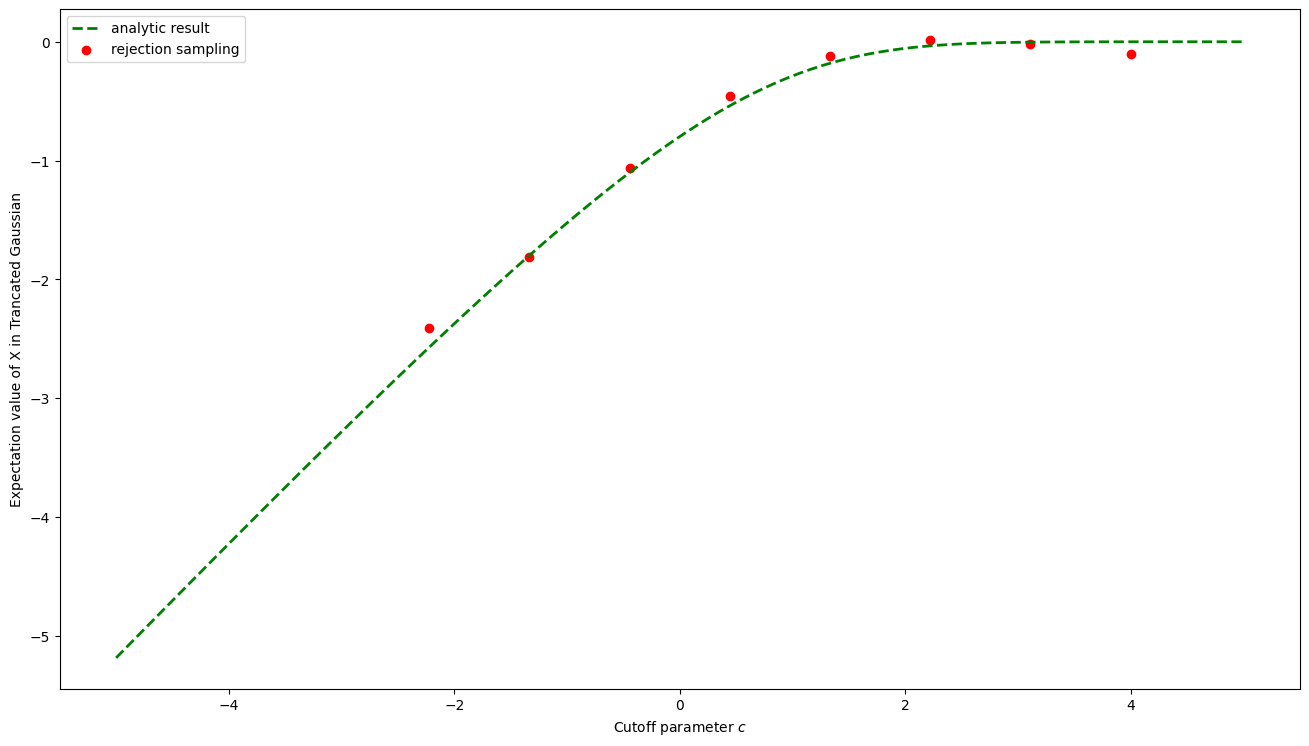

In [ ]:
def e(x):
    mu = 0.0
    sigma = 1.0
    return mu - sigma*stats.norm.pdf(x,loc=mu,scale=sigma) / stats.norm.cdf(x, loc=mu, scale=sigma)

mvar=[]
cvar = np.linspace(-4.0, 4.0, 10)
for c in cvar:
    s = rejection_sampling(iter=100)
    mvar.append(np.mean(s))
    print(c,len(s))

fig = plt.figure(dpi=100, figsize=(16,9))
plt.scatter(cvar,mvar,color='r',label='rejection sampling')
x = np.linspace(-5.0, 5.0, 100)
plt.plot(x,e(x),linestyle='dashed',color='g',linewidth=2, label='analytic result')
plt.ylabel("Expectation value of X in Trancated Gaussian")
plt.xlabel("Cutoff parameter $c$")
plt.legend()
plt.show()

Cutoff parameter cが小さいとRejectが多くて，実際に$c=-4$では一度もAcceptされていない．これは提案分布が大きすぎて，ダメダメなのだ．

モンテカルロ法の誤差も計算してみたい．．．

## Importance Sampling

Importance Samplingもやってみた．どちらもcが小さいときには困難点がある．Rejection SamplingはrejectばかりでAcceptされず，サンプル数は少ない．一方で，Importance Samplingではrejectという操作はないために，サンプル数は繰り返し回数だけあるが，weightがほとんどがゼロになっていて，実質的にweightが有意に存在するサンプルが少なくなってる．

-4.0 10000
-3.111111111111111 10000
-2.2222222222222223 10000
-1.3333333333333335 10000
-0.44444444444444464 10000
0.44444444444444464 10000
1.333333333333333 10000
2.2222222222222214 10000
3.1111111111111107 10000
4.0 10000


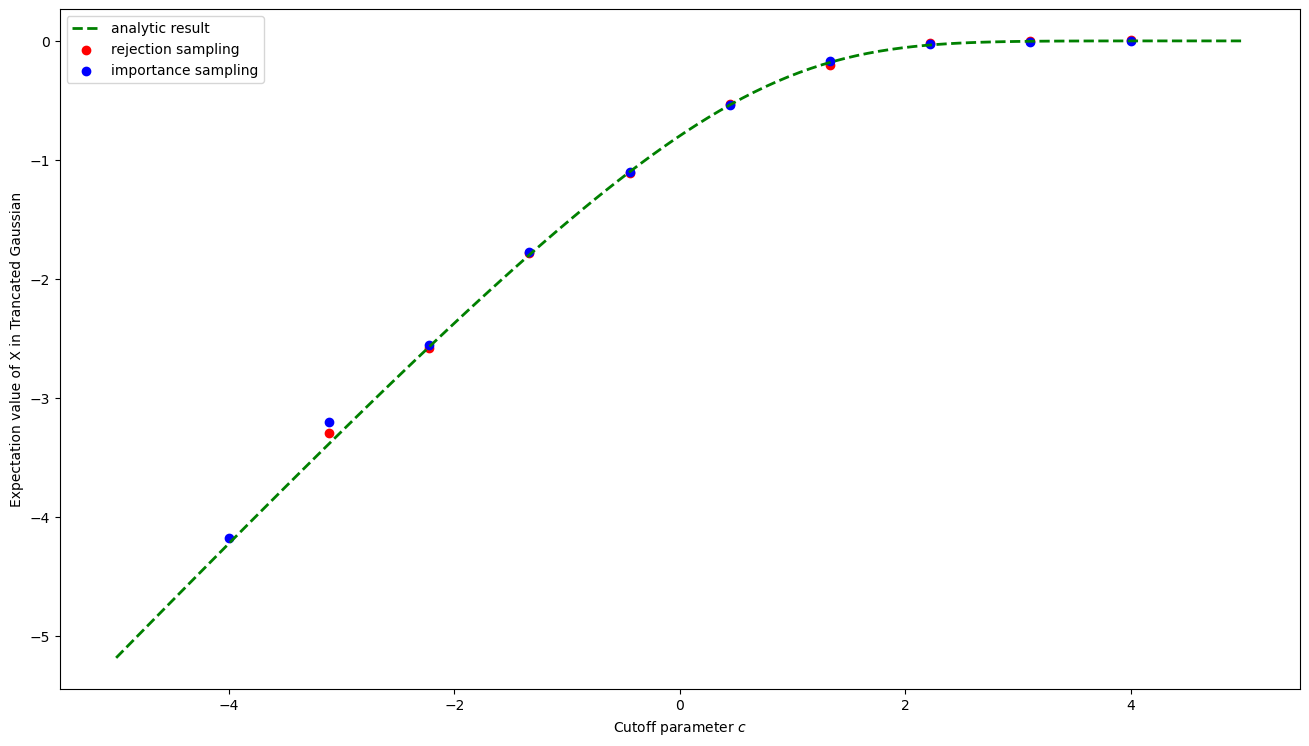

In [ ]:
def importance_sampling(iter=1000):
    samples = []
    weights = []

    for i in range(iter):
        z = np.random.normal(0, 1.0)
        u = p(z,c)/q(z)

        samples.append(z)
        weights.append(u)

    return np.array(samples),np.array(weights)

mvar_is = []
cvar = np.linspace(-4.0, 4.0, 10)
for c in cvar:
    s,w = importance_sampling(iter=10000)
    mvar_is.append(np.dot(s,w)/np.sum(w))
    print(c,len(s))
    
fig = plt.figure(dpi=100, figsize=(16,9))
plt.scatter(cvar,mvar,color='r',label='rejection sampling')
plt.scatter(cvar,mvar_is,color='b',label='importance sampling')
x = np.linspace(-5.0, 5.0, 100)
plt.plot(x,e(x),linestyle='dashed',color='g',linewidth=2, label='analytic result')
plt.ylabel("Expectation value of X in Trancated Gaussian")
plt.xlabel("Cutoff parameter $c$")
plt.legend()
plt.show()
